# 📊 Reddit Hashtag/Keyword Trend Analyzer (Demo Notebook)

This notebook demonstrates the **core functionalities** of the Reddit Trend Analyzer using Python and SQLite.

---

In [1]:
# ✅ Install Dependencies (if not already installed)
!pip install praw textblob pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.0 MB/s eta 0:00:00


## 1. Collect Reddit Posts and Store in SQLite

In [3]:
import praw
import sqlite3
from textblob import TextBlob
from datetime import datetime

# Setup Reddit API (replace with your credentials)
reddit = praw.Reddit(client_id='AarzRB8i4SBJOsNVatfDLA',
                     client_secret='R277jKsCipUauQHsuGc0d6mJrpAJUA',
                     user_agent='Sensitive_Piano_2237')

# Connect to SQLite database (in Colab, using local file)
conn = sqlite3.connect('reddit_trends.db')
cursor = conn.cursor()

# Create table if not exists
cursor.execute('''
CREATE TABLE IF NOT EXISTS posts (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    keyword TEXT,
    title TEXT,
    score INTEGER,
    url TEXT,
    created_utc TEXT,
    sentiment REAL
)
''')
conn.commit()

# Define keywords
keywords = ['AI', 'ChatGPT', 'Python', 'Quantum Computing']

# Collect posts
subreddit = reddit.subreddit('technology')
for submission in subreddit.new(limit=50):
    for keyword in keywords:
        if keyword.lower() in submission.title.lower():
            sentiment = TextBlob(submission.title).sentiment.polarity
            cursor.execute('''
                INSERT INTO posts (keyword, title, score, url, created_utc, sentiment)
                VALUES (?, ?, ?, ?, ?, ?)
            ''', (
                keyword,
                submission.title,
                submission.score,
                submission.url,
                datetime.utcfromtimestamp(submission.created_utc).isoformat(),
                sentiment
            ))
            print(f"Stored post: {submission.title}")

conn.commit()
conn.close()

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Stored post: Star Wars Shows the Future of AI Special Effects and It Sucks | Industrial Light & Magic revealed a short film showcasing how it wants to use generative AI for Star Wars and it’s completely embarrassing.
Stored post: Qatar's $400 million jet offered as free Air Force One stop-gap, but security and tech overhauls would cost millions | It could take years to retrofit the "flying palace" for presidential security
Stored post: HBO Max Is Back as Warner Bros. Discovery Rebrands Streaming Service – Again
Stored post: License Plate Reader Company Flock Is Building a Massive People Lookup Tool, Leak Shows | Flock, which has license plate readers (LPRs) all around the country, wants police to be able to “jump from LPR to person,” according to leaked audio obtained by 404 Media.
Stored post: College Professors Are Using ChatGPT. Some Students Aren’t Happy.
Stored post: Amazon's Bezos leads new investment in AI data company Toloka
Stored post: Microsoft facing multibillion legal clai

## 2. Analyze and Visualize the Data

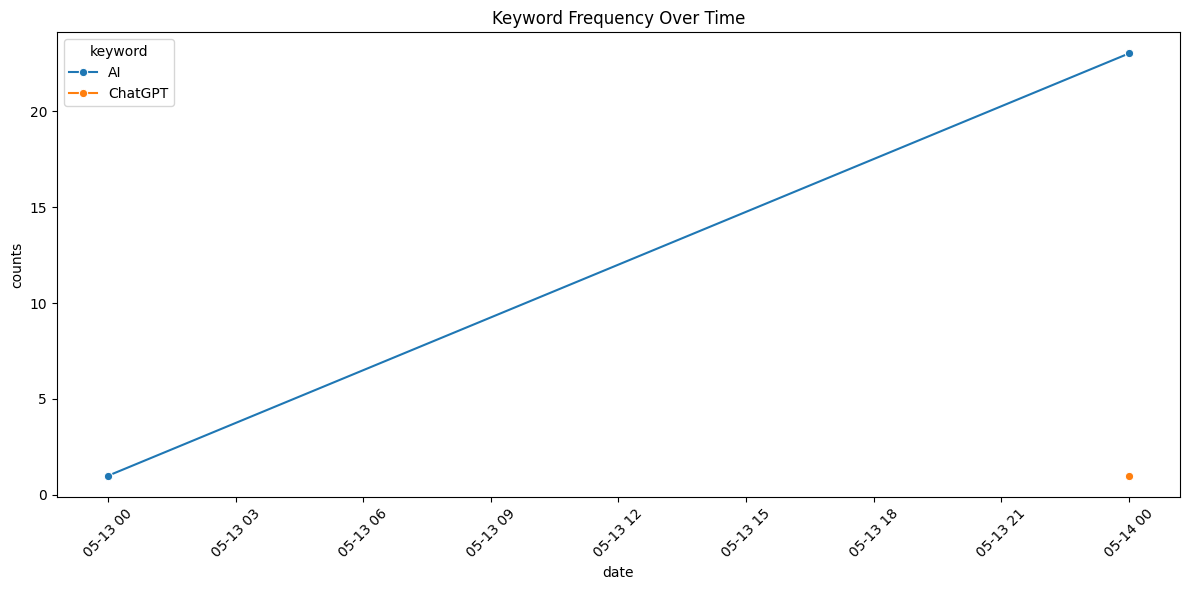

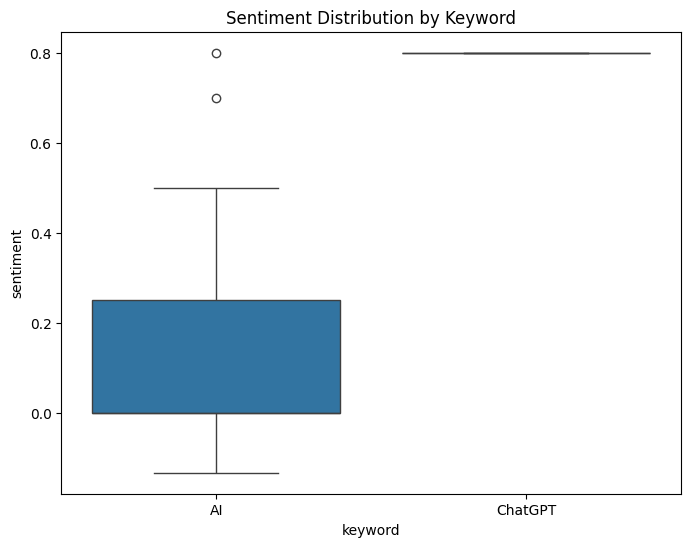

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect('reddit_trends.db')
df = pd.read_sql_query("SELECT * FROM posts", conn)
conn.close()

df['created_utc'] = pd.to_datetime(df['created_utc'])
df['date'] = df['created_utc'].dt.date

# Frequency Trend
freq = df.groupby(['date', 'keyword']).size().reset_index(name='counts')

plt.figure(figsize=(12, 6))
sns.lineplot(data=freq, x='date', y='counts', hue='keyword', marker='o')
plt.title('Keyword Frequency Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='keyword', y='sentiment')
plt.title('Sentiment Distribution by Keyword')
plt.show()

## 3. Query Top Posts and Average Sentiment

In [5]:
# Top 5 posts by score
conn = sqlite3.connect('reddit_trends.db')

top_posts = pd.read_sql_query('''
    SELECT keyword, title, score, url, created_utc
    FROM posts
    ORDER BY score DESC
    LIMIT 5
''', conn)
print(top_posts)

# Average sentiment by keyword
avg_sentiment = pd.read_sql_query('''
    SELECT keyword, ROUND(AVG(sentiment), 3) as avg_sentiment, COUNT(*) as post_count
    FROM posts
    GROUP BY keyword
    ORDER BY avg_sentiment DESC
''', conn)
print(avg_sentiment)

conn.close()

  keyword                                              title  score  \
0      AI  89 million Steam account details just got leak...   3101   
1      AI  Transportation Secretary Sean Duffy Changed Hi...   1584   
2      AI  Anti-Defamation League Pushes Google to Reject...    178   
3      AI  Trump administration officially rescinds Biden...    150   
4      AI  Google’s Android 16 Takes Aim at Phone and Tex...    128   

                                                 url          created_utc  
0  https://www.xda-developers.com/89-million-stea...  2025-05-14T12:02:29  
1  https://gizmodo.com/transportation-secretary-s...  2025-05-14T12:21:38  
2  https://gizmodo.com/anti-defamation-league-pus...  2025-05-14T13:09:03  
3  https://techcrunch.com/2025/05/13/trump-admini...  2025-05-14T12:04:10  
4  https://www.vice.com/en/article/googles-androi...  2025-05-14T03:37:24  
   keyword  avg_sentiment  post_count
0  ChatGPT          0.800           1
1       AI          0.159          24


## 4. Word Cloud of Frequent Words in Titles

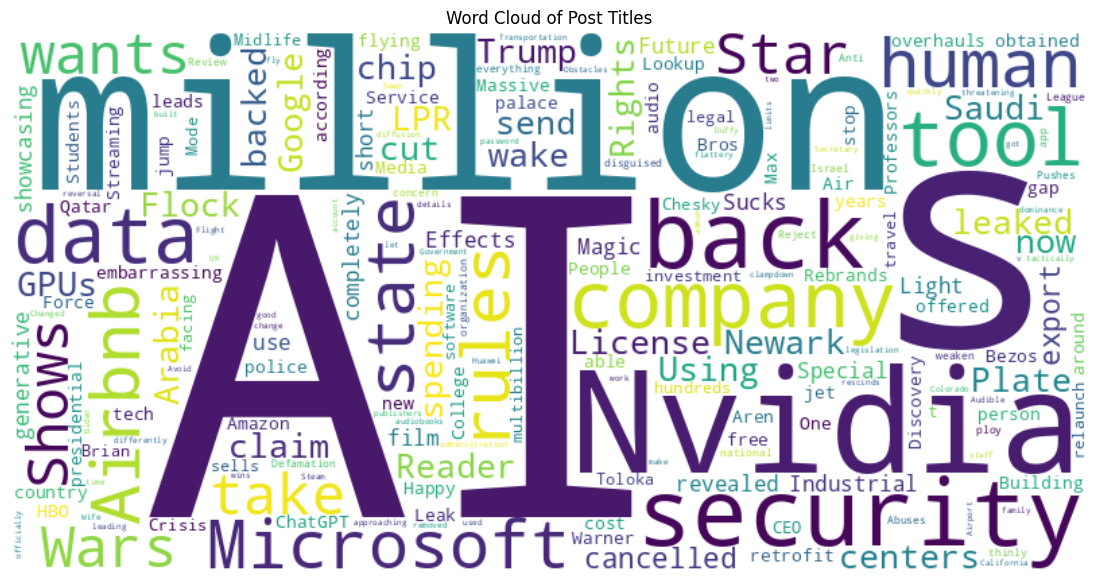

In [6]:
from wordcloud import WordCloud, STOPWORDS

# Combine all titles
text = ' '.join(df['title'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=set(STOPWORDS)).generate(text)

# Plot
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Post Titles')
plt.show()

## 5. Keyword Popularity Pie Chart

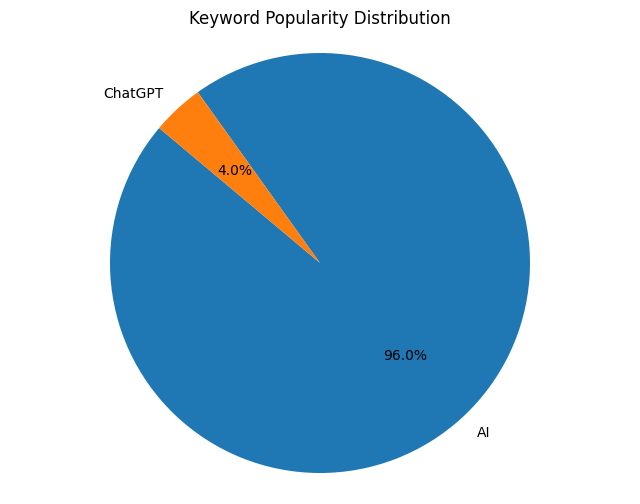

In [7]:
# Pie chart of keyword distribution
keyword_counts = df['keyword'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(keyword_counts, labels=keyword_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Keyword Popularity Distribution')
plt.axis('equal')
plt.show()

## 6. Sentiment Over Time by Keyword

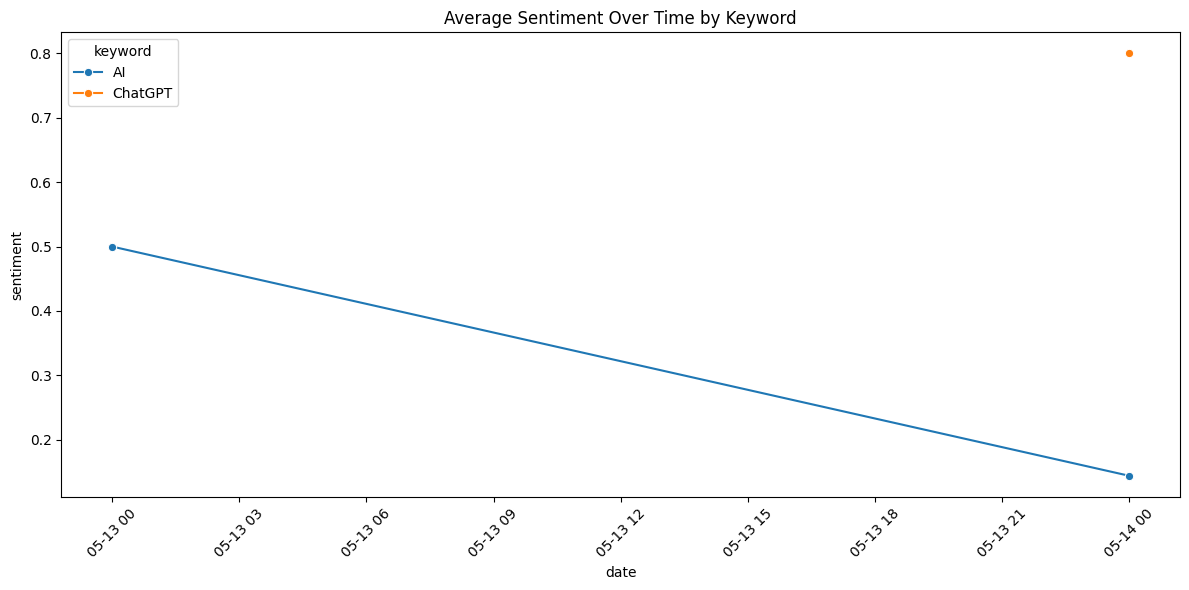

In [8]:
# Sentiment over time (daily average)
sentiment_trend = df.groupby(['date', 'keyword'])['sentiment'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_trend, x='date', y='sentiment', hue='keyword', marker='o')
plt.title('Average Sentiment Over Time by Keyword')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Export Data to CSV

In [9]:
# Export to CSV
df.to_csv('reddit_trend_analyzed_data.csv', index=False)
print("✅ Data exported to 'reddit_trend_analyzed_data.csv'")

✅ Data exported to 'reddit_trend_analyzed_data.csv'


# 📊 Reddit Hashtag/Keyword Trend Analyzer (Advanced Version)

In this section:
- Collect Reddit posts for selected keywords.
- Store them in SQLite database.
- Perform detailed analysis.
- Generate multiple insightful visualizations.
- Modularized code with reusable functions.


In [10]:
import praw
import sqlite3
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
import os

In [11]:
def init_reddit_api(client_id, client_secret, user_agent):
    return praw.Reddit(client_id=client_id,
                       client_secret=client_secret,
                       user_agent=user_agent)

def init_db(db_file='reddit_trends.db'):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS posts (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            keyword TEXT,
            title TEXT,
            score INTEGER,
            url TEXT,
            created_utc TEXT,
            sentiment REAL
        )
    ''')
    conn.commit()
    return conn

def collect_and_store_posts(reddit, conn, keywords, subreddit_name='technology', limit=100):
    cursor = conn.cursor()
    subreddit = reddit.subreddit(subreddit_name)
    for submission in subreddit.new(limit=limit):
        for keyword in keywords:
            if keyword.lower() in submission.title.lower():
                sentiment = TextBlob(submission.title).sentiment.polarity
                cursor.execute('''
                    INSERT INTO posts (keyword, title, score, url, created_utc, sentiment)
                    VALUES (?, ?, ?, ?, ?, ?)
                ''', (
                    keyword,
                    submission.title,
                    submission.score,
                    submission.url,
                    datetime.utcfromtimestamp(submission.created_utc).isoformat(),
                    sentiment
                ))
    conn.commit()

def load_data_from_db(conn):
    df = pd.read_sql_query("SELECT * FROM posts", conn)
    df['created_utc'] = pd.to_datetime(df['created_utc'])
    df['date'] = df['created_utc'].dt.date
    return df

def plot_keyword_frequency(df):
    freq = df.groupby(['date', 'keyword']).size().reset_index(name='counts')
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=freq, x='date', y='counts', hue='keyword', marker='o')
    plt.title('Keyword Frequency Over Time')
    plt.xticks(rotation=45)
    plt.show()

def plot_sentiment_distribution(df):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='keyword', y='sentiment')
    plt.title('Sentiment Distribution by Keyword')
    plt.show()

def plot_sentiment_trend(df):
    sentiment_trend = df.groupby(['date', 'keyword'])['sentiment'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=sentiment_trend, x='date', y='sentiment', hue='keyword', marker='o')
    plt.title('Average Sentiment Over Time by Keyword')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_keyword_pie_chart(df):
    plt.figure(figsize=(8, 6))
    df['keyword'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
    plt.title('Keyword Popularity Distribution')
    plt.axis('equal')
    plt.show()

def plot_word_cloud(df):
    text = ' '.join(df['title'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=set(STOPWORDS)).generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Post Titles')
    plt.show()

def plot_top_posts_table(df, n=10):
    top_posts = df.sort_values('score', ascending=False).head(n)
    display(top_posts[['keyword', 'title', 'score', 'url', 'created_utc']])

def plot_sentiment_heatmap(df):
    pivot = df.pivot_table(values='sentiment', index='date', columns='keyword', aggfunc='mean')
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title('Sentiment Heatmap (Avg Sentiment per Day)')
    plt.show()

def export_to_csv(df, filename='reddit_trend_data.csv'):
    df.to_csv(filename, index=False)
    print(f"Data exported to {filename}")


## 🔥 Demonstration with Different Keyword Sets

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



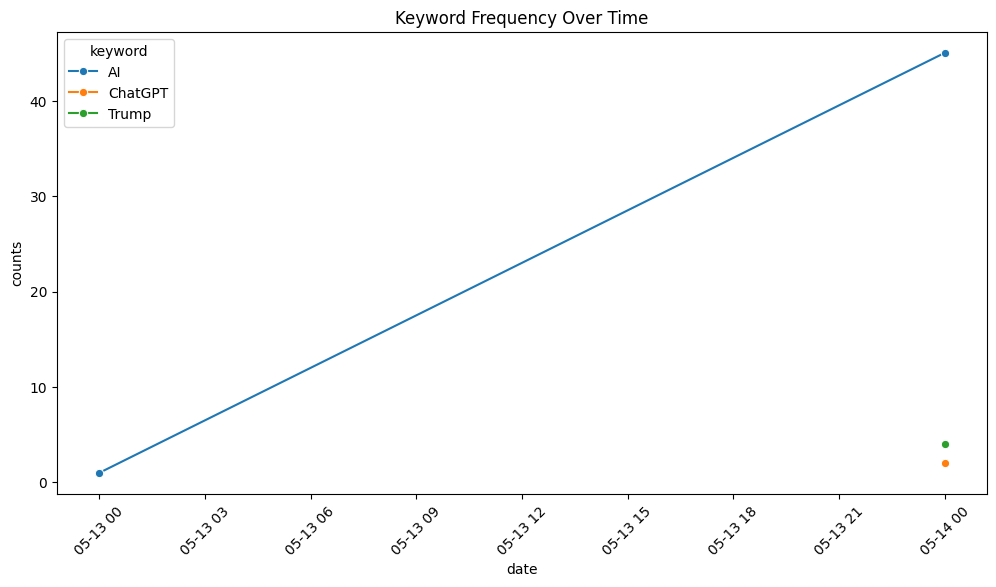

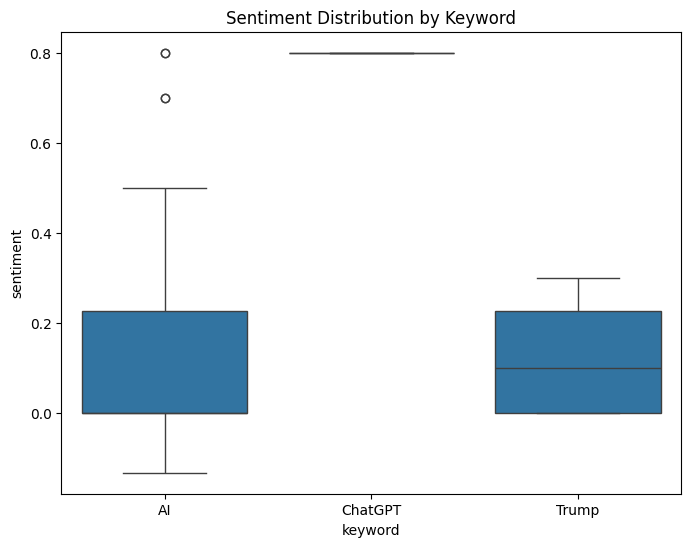

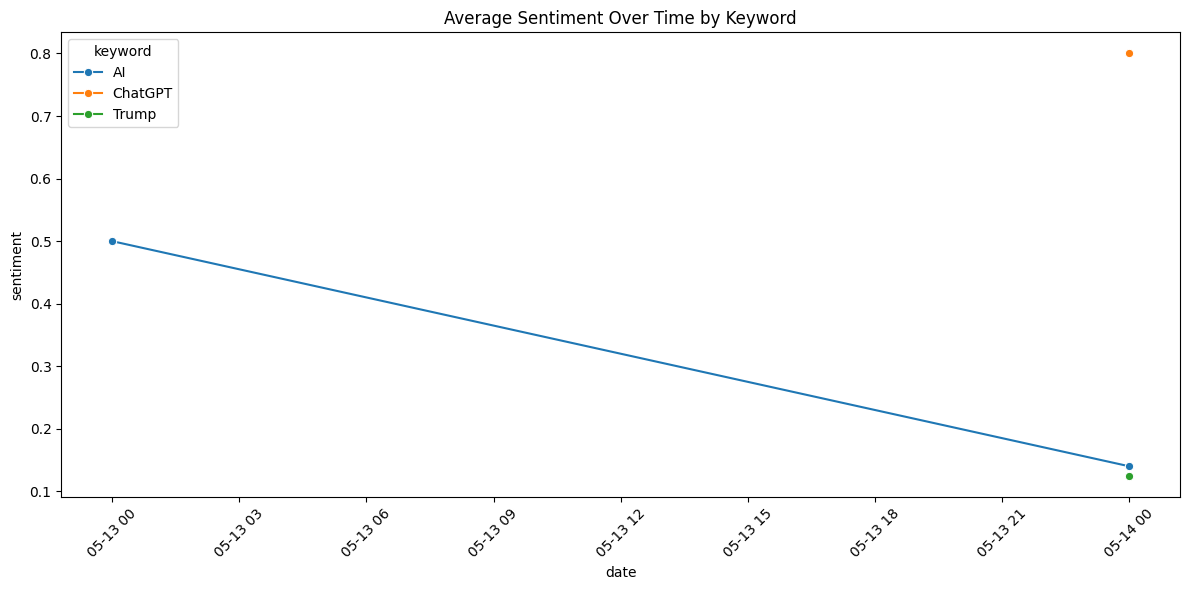

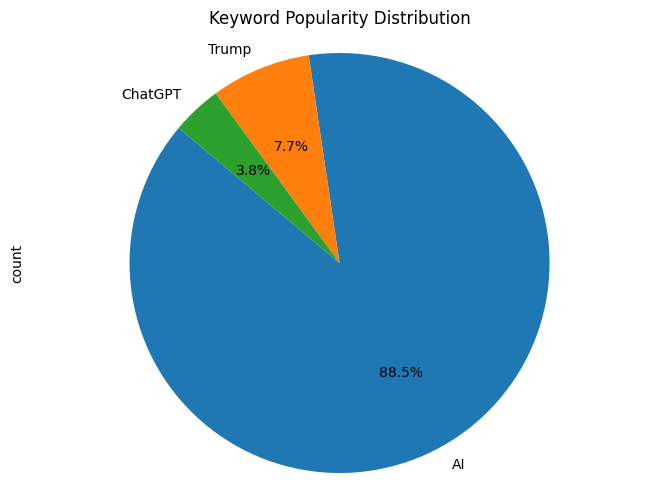

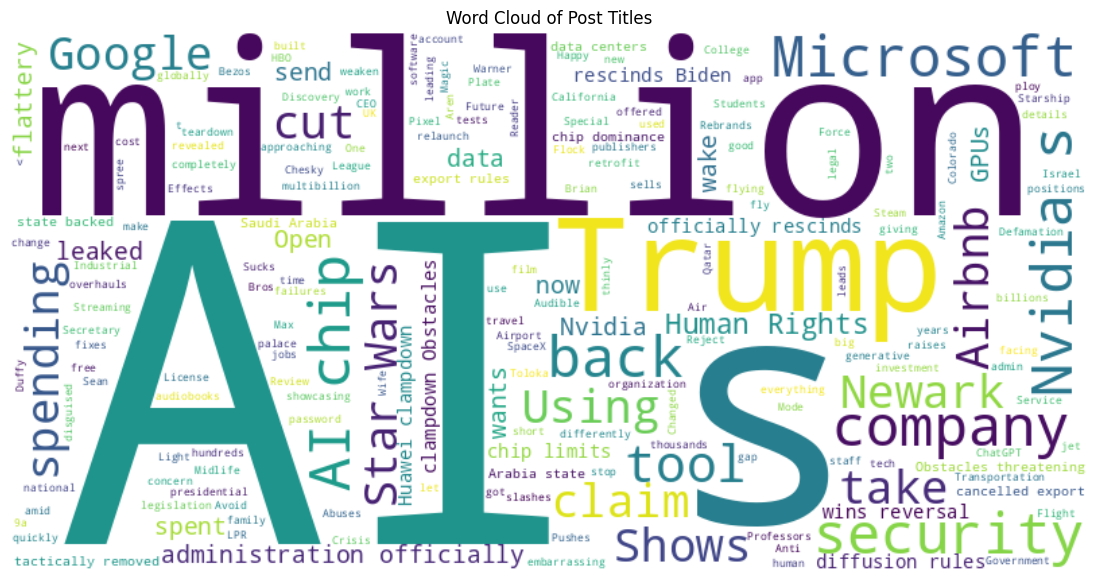

,keyword,title,score,url,created_utc
39,AI,89 million Steam account details just got leak...,4635,https://www.xda-developers.com/89-million-stea...,2025-05-14 12:02:29
12,AI,89 million Steam account details just got leak...,3101,https://www.xda-developers.com/89-million-stea...,2025-05-14 12:02:29
35,AI,Transportation Secretary Sean Duffy Changed Hi...,2040,https://gizmodo.com/transportation-secretary-s...,2025-05-14 12:21:38
9,AI,Transportation Secretary Sean Duffy Changed Hi...,1584,https://gizmodo.com/transportation-secretary-s...,2025-05-14 12:21:38
51,Trump,$TRUMP meme coin buyers spent more than $140 m...,1114,https://www.cbsnews.com/news/trump-meme-coin-t...,2025-05-14 00:18:45
34,AI,Anti-Defamation League Pushes Google to Reject...,296,https://gizmodo.com/anti-defamation-league-pus...,2025-05-14 13:09:03
38,Trump,Trump administration officially rescinds Biden...,207,https://techcrunch.com/2025/05/13/trump-admini...,2025-05-14 12:04:10
37,AI,Trump administration officially rescinds Biden...,207,https://techcrunch.com/2025/05/13/trump-admini...,2025-05-14 12:04:10
8,AI,Anti-Defamation League Pushes Google to Reject...,178,https://gizmodo.com/anti-defamation-league-pus...,2025-05-14 13:09:03
11,AI,Trump administration officially rescinds Biden...,150,https://techcrunch.com/2025/05/13/trump-admini...,2025-05-14 12:04:10


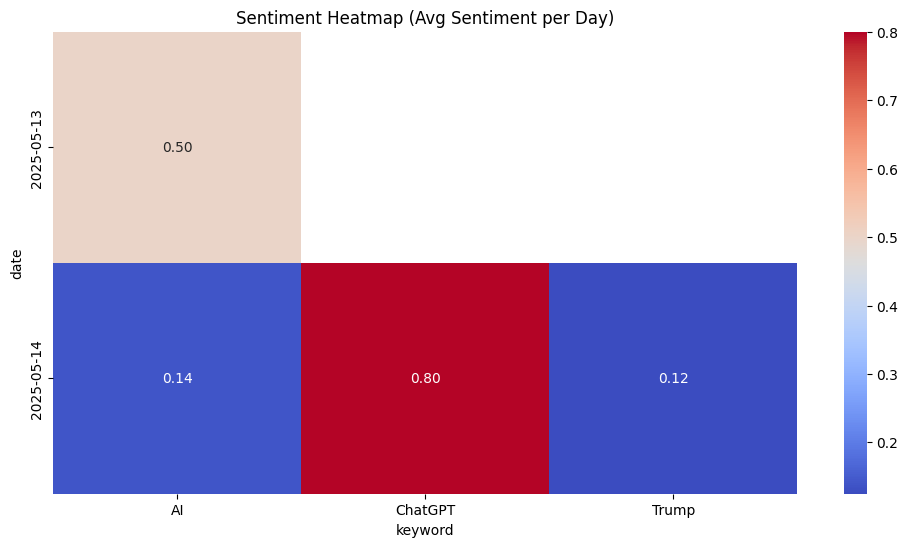

Data exported to reddit_trend_data.csv


In [12]:
# Initialize API and DB
reddit = init_reddit_api('AarzRB8i4SBJOsNVatfDLA', 'R277jKsCipUauQHsuGc0d6mJrpAJUA', 'Sensitive_Piano_2237')
conn = init_db()

# Collect and store data
keywords_set1 = ['AI', 'ChatGPT', 'Python', 'Trump', 'Musk']
collect_and_store_posts(reddit, conn, keywords_set1, limit=50)

# Load data
df1 = load_data_from_db(conn)

# Plot all insights
plot_keyword_frequency(df1)
plot_sentiment_distribution(df1)
plot_sentiment_trend(df1)
plot_keyword_pie_chart(df1)
plot_word_cloud(df1)
plot_top_posts_table(df1)
plot_sentiment_heatmap(df1)

# Export
export_to_csv(df1)